## Train model using contrastive loss only

In [1]:
import os
import sys
import random

p = os.path.abspath('../')
sys.path.insert(1, p)

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"

import transformers
transformers.logging.set_verbosity_error()

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

from datasets import Dataset, load_dataset, Split

import seaborn as sns
sns.set_theme(color_codes=True)

from transformers import DataCollatorWithPadding, AutoModel, Trainer, TrainingArguments
import evaluate

from src.contrastive_transformers.collators import TextCollator
from src.contrastive_transformers.datasets import AutoAugmentDataset, DatasetWithPositives
from src.contrastive_transformers.trainers import ContrastiveTrainer
from src.contrastive_transformers.losses import SupConLoss 

from src.utils.utils import * 

seed = 7631
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

In [2]:
smm4h20 = load_dataset('KevinSpaghetti/smm4h20')
cadec = load_dataset('KevinSpaghetti/cadec')

meddra_ontology = pd.read_csv('./data/processed/meddra_ontology.csv')
all_pts = meddra_ontology['term_PT'].unique()

llt_pt_examples = pd.read_csv('./data/processed/llt_pt_examples.csv')
all_llts = llt_pt_examples['term_LLT'].unique()

llt_to_pt_mapping = dict(llt_pt_examples[['term_LLT', 'term_PT']].itertuples(index=False))

all_pts = load_dataset('KevinSpaghetti/all_pts', split=Split.ALL)
pt_vocab = dict(zip(all_pts['term'], all_pts['label']))
index_to_label = dict(zip(all_pts['label'], all_pts['term']))
print(len(pt_vocab))

Using custom data configuration KevinSpaghetti--smm4h20-9b0cef5ffb10261f
Found cached dataset parquet (/home/kevinds/.cache/huggingface/datasets/KevinSpaghetti___parquet/KevinSpaghetti--smm4h20-9b0cef5ffb10261f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration KevinSpaghetti--cadec-d97aca76af8be810
Found cached dataset parquet (/home/kevinds/.cache/huggingface/datasets/KevinSpaghetti___parquet/KevinSpaghetti--cadec-d97aca76af8be810/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration KevinSpaghetti--all_pts-28f171117b934745
Found cached dataset parquet (/home/kevinds/.cache/huggingface/datasets/KevinSpaghetti___parquet/KevinSpaghetti--all_pts-28f171117b934745/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


24571


In [3]:
smm4h20_train_df = pd.DataFrame(smm4h20['train'])
cadec_train_df = pd.DataFrame(cadec['train'])
train_pairs = pd.concat([
    #smm4h20_train_df[['ade', 'term_PT']],
    cadec_train_df[['ade', 'term_PT']],
    #llt_pt_examples[['term_LLT', 'term_PT']].rename({'term_LLT': 'ade'}, axis=1),
    #meddra_ontology[['term_HLT', 'term_PT']].rename({'term_HLT': 'ade'}, axis=1),
    #meddra_ontology[['term_HLGT', 'term_PT']].rename({'term_HLGT': 'ade'}, axis=1),
    #meddra_ontology[['term_SOC', 'term_PT']].rename({'term_SOC': 'ade'}, axis=1),
], axis=0).reset_index(drop=True)

In [4]:
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
train = AutoAugmentDataset(train_pairs['ade'], train_pairs['term_PT'], return_negative=False)
collator = TextCollator(tokenizer, max_length=32, vocab=pt_vocab)

In [5]:
model = AutoModel.from_pretrained(model_name, cache_dir='./cache/')
model.train()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [6]:
contrastive_head = nn.Sequential(
    nn.Linear(768, 768 // 2),
    nn.ReLU(),
    nn.Linear(768 // 2, 768 // 4),
)

ct_loss = SupConLoss(0.2)

def loss_adapter(anchor_encodings, 
                 positive_encodings, 
                 negative_encodings, 
                 labels, 
                 negative_labels, 
                 anchor_outputs, positive_outputs, negative_outputs):
    contrastive_loss = (
        ct_loss(anchor_encodings, positive_encodings, labels) + 
        ct_loss(positive_encodings, anchor_encodings, labels)
    )
    return contrastive_loss

In [8]:
cb = StoreLosses()

training_args = TrainingArguments(
    output_dir="./models/projection-head-eval/linear-relu-1",
    resume_from_checkpoint=False,
    do_train=True,
    do_eval=False,
    save_strategy='epoch',
    save_total_limit=1,
    num_train_epochs=32,
    learning_rate=2e-4,
    disable_tqdm=False,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=1,
    warmup_steps=20,
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=16,
    dataloader_num_workers=4,
    fp16=True,
    fp16_opt_level='03',
    report_to="none",
    optim="adamw_torch"
)

trainer = ContrastiveTrainer(
    loss=loss_adapter,
    head=contrastive_head,
    use_negatives=False,
    model=model,
    args=training_args,
    train_dataset=train,
    data_collator=collator,
    callbacks=[cb]
)

trainer.train()

PyTorch: setting up devices
Using cuda_amp half precision backend
***** Running training *****
  Num examples = 4745
  Num Epochs = 32
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4768
  Number of trainable parameters = 109918464


Step,Training Loss
16,193.835200
32,115.819300
48,89.588300
64,70.268400


KeyboardInterrupt: 

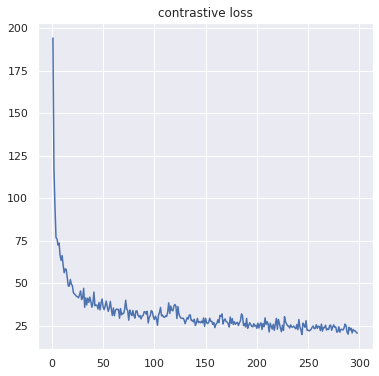

In [32]:
fig = plt.figure(figsize=(6, 6))
contr_ax = plt.subplot()
contr_ax.set_title("contrastive loss")
sns.lineplot(x=range(1, len(cb.train_loss) + 1), y=cb.train_loss, ax=contr_ax)

fig.show()